In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!git clone "https://github.com/kaledai069/INFERENCE-Extractive-CA-Model"
%cd INFERENCE-Extractive-CA-Model

Cloning into 'INFERENCE-Extractive-CA-Model'...
remote: Enumerating objects: 138, done.
remote: Counting objects: 100% (138/138), done.
remote: Compressing objects: 100% (108/108), done.
remote: Total 138 (delta 68), reused 97 (delta 29), pack-reused 0
Receiving objects: 100% (138/138), 3.28 MiB | 25.23 MiB/s, done.
Resolving deltas: 100% (68/68), done.
/content/INFERENCE-Extractive-CA-Model


In [ ]:
!pip install transformers
!pip install faiss-cpu
!pip install puzpy
!pip install wordsegment
!pip install git+https://github.com/alexdej/puzpy.git
!pip install streamlit

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.7/7.7 MB 28.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 295.0/295.0 kB 36.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.8/3.8 MB 64.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 63.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 33.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.6/17.6 MB 72.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.8/4.8 MB 21.4 MB/s eta 0:00:00
  Cloning https://github.com/alexdej/puzpy.git to /tmp/pip-req-build-74atho7w
  Running command git clone --filter=blob:none --quiet https://github.com/alexdej/puzpy.git /tmp/pip-req-build-74atho7w
  Resolved https://github.com/alexdej/puzpy.git to commit 28e22b5efe90f2f144919e3c690d51cb38389227
  Preparing metadata (setup.py) ... done
  Created wheel for puzpy: filename=puzpy-0.2.4-py2.py3-none-any.whl size=8771 sha256=abbcc59031196a97b

In [ ]:
import re
from collections import defaultdict
import string
import requests
import json
from scipy.special import softmax
import numpy as np
from Models_inf import answer_clues, setup_closedbook
from Strict_json import json_CA_json_converter
from Crossword_inf import Crossword
import datetime
from tqdm import tqdm

In [ ]:
def getGrid(dateStr):
    headers = {
        'Referer': 'https://www.xwordinfo.com/JSON/'
    }
    # mm/dd/yyyy
    url = 'https://www.xwordinfo.com/JSON/Data.ashx?date=' + dateStr
    response = requests.get(url, headers=headers)
    context = {}
    grid_data = {}
    if response.status_code == 200:
        bytevalue = response.content
        jsonText = bytevalue.decode('utf-8').replace("'", '"')
        grid_data = json.loads(jsonText)
        return grid_data
    else:
        print(f"Request failed with status code {response.status_code}.")

In [ ]:
def extract_data_from_puz(puzzle):
    puzzle = json_CA_json_converter(puzzle, False)
    for dim in ['across', 'down']:
        for grid_num in puzzle['clues'][dim].keys():
            clue_answer_list = puzzle['clues'][dim][grid_num]
            clue_section = clue_answer_list[0]
            ans_section = clue_answer_list[1]
            clue_section = clue_section.replace("&quot;", "").replace("&#39;", "").replace("<em>", "").replace("</em>", "")
            puzzle['clues'][dim][grid_num] = [clue_section, ans_section]

    all_clues = puzzle['clues']
    across_clue_data = []
    down_clue_data = []

    for dim in ['across', 'down']:
        for key in all_clues[dim].keys():
            clue = all_clues[dim][key][0]
            if dim == 'across':
                across_clue_data.append([key, clue])
            else:
                down_clue_data.append([key, clue])

    all_clue_info = [across_clue_data, down_clue_data]
    crossword = Crossword(puzzle)
    all_pairs = []
    for var in crossword.variables:
        all_pairs.append((crossword.variables[var]['clue'], crossword.variables[var]['gold']))
    return all_pairs

In [ ]:
start_date = datetime.date(2023, 7, 1)
end_date = datetime.date(2023, 7, 30)
overall_data = []
current_date = start_date

for i in tqdm(range((end_date - start_date).days), ncols = 160):
    formatted_date = current_date.strftime('%m/%d/%Y')
    try:
        puzzle = getGrid(formatted_date)
        overall_data.extend(extract_data_from_puz(puzzle))
    except:
        print("Problem with fetching data!!!")
    current_date += datetime.timedelta(days = 1)

 79%|█████████████████████████████████████████████████████████████████████████████████████████████████▌                         | 23/29 [00:18<00:04,  1.25it/s]

Problem with fetching data!!!


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 29/29 [00:24<00:00,  1.19it/s]


In [ ]:
all_clues = [clue for clue, _ in overall_data]
all_answers = [answer for _, answer in overall_data]
print(len(all_clues))

2249


In [ ]:
MODEL_PATH = "/content/drive/MyDrive/distilbert_EPOCHs_7_COMPLETE.bin",
ANS_TSV_PATH = "/content/drive/MyDrive/all_answer_list.tsv",
DENSE_EMBD_PATH = "/content/drive/MyDrive/distilbert_7_epochs_embeddings.pkl"
MODEL_TYPE = "distilbert"

In [ ]:
dpr = setup_closedbook(MODEL_PATH, ANS_TSV_PATH, DENSE_EMBD_PATH, 0, MODEL_TYPE)
all_words, all_scores = answer_clues(dpr, all_clues, max_answers = 10000, output_strings = True)

In [ ]:
count = 0
for i, answer_found_list in enumerate(all_words):
    correct_answer = all_answers[i]
    if correct_answer in answer_found_list[:2000]:
        count += 1
print(count / len(all_words))

0.8685128205128205


In [ ]:
# finding MRR
K_value = 40000
index_values = []
scores_values = []

for i, answer_found_list in enumerate(all_words):
  correct_answer = all_answers[i]
  if correct_answer in answer_found_list[:K_value]:
    index_corr_ans = answer_found_list.index(correct_answer)
    scores_values.append(all_scores[i][index_corr_ans])
    index_values.append(answer_found_list.index(correct_answer) + 1)
  else:
    index_values.append(0)
    scores_values.append(0)

In [ ]:
dcg_value = 0
indcg_value = 0
for i, value in enumerate(index_values):
  curr_conf_score = scores_values[i]
  if curr_conf_score > 50 and curr_conf_score <= 56.5:
    rel_value = 5
  elif curr_conf_score > 46.5 and curr_conf_score <= 50:
    rel_value = 4
  elif curr_conf_score > 56.5 and curr_conf_score <= 59:
    rel_value = 3.5
  elif curr_conf_score > 43.5 and curr_conf_score <= 46.5:
    rel_value = 2.5
  elif curr_conf_score > 59 and curr_conf_score <= 66.5:
    rel_value = 5.0
  elif curr_conf_score > 33.5 and curr_conf_score <= 43.5:
    rel_value = 1.0
  elif curr_conf_score > 43.5 and curr_conf_score <= 46.5:
    rel_value = 2.0
  elif curr_conf_score <= 33.5:
    rel_value = 0
  elif curr_conf_score > 66.5:
    rel_value = 4.5
  if rel_value == 0:
    dcg_value += 1 / np.log2(len(all_words[0]) + 1)
    indcg_value += 5
  else:
    dcg_value += rel_value / np.log2(value + 1)
    indcg_value += 5 / np.log2(value + 1)
print(dcg_value / indcg_value)

0.8123740946767822


(array([ 641.,    0.,    0.,    0.,    0.,    8.,   98., 1779., 2251.,
          98.]),
 array([ 0.        ,  6.62399521, 13.24799042, 19.87198563, 26.49598083,
        33.11997604, 39.74397125, 46.36796646, 52.99196167, 59.61595688,
        66.23995209]),
 <BarContainer object of 10 artists>)

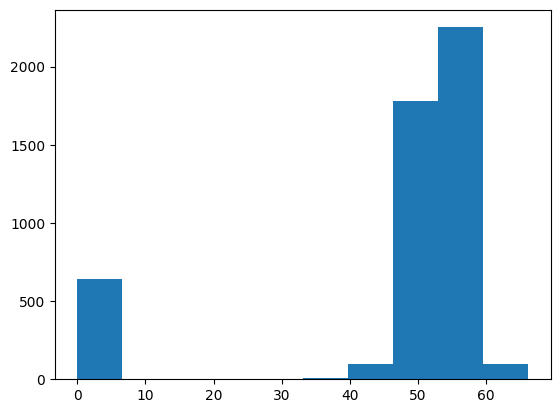

In [ ]:
import matplotlib.pyplot as plt

plt.hist(scores_values, bins = 10)

In [ ]:
count = 0
output_data_list = []
for i, candidate_ans_list in enumerate(all_words):
  correct_ans = all_answers[i]
  clue_instance = all_clues[i]
  if correct_ans in candidate_ans_list:
    ans_index = candidate_ans_list.index(correct_ans)
    if ans_index < 10:
      count += 1
      for j, candidate_ans in enumerate(candidate_ans_list[:5]):
        output_data_list.append((clue_instance, candidate_ans, all_scores[i][j], correct_ans, ans_index))
  if count == 10:
    break

In [ ]:
import pandas as pd
df = pd.DataFrame(output_data_list, columns = ['Clue', 'Candidate Answer', 'Dot Product Score', 'Correct Answer', 'Ranked At'])
df.to_excel('/content/clue_answer.xlsx')